# Seasonal variation of the simulated ionospheric potential
The source code of Figures 2.1, 2.2, 2.S2 and 2.S3

### Importing libraries

In [1]:
import matplotlib.pyplot as plt

import datetime as dt

import numpy as np

### Helper functions, variables and classes

In [2]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.
    
    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample
    
    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

In [3]:
# a helper function to show the peak-to-peak amplitude
def draw_arrows(ax=None, miny=0, maxy=1, exty=1,
                arrow_pos=12, text_pos=12.2, ampl=0, inward=False):
    arrow_props = {
        "patchA": None, "patchB": None,
        "shrinkA": 0.0, "shrinkB": 0.0,
        "connectionstyle": "arc3,rad=0.", "fc": "black",
        "linewidth": 0.5
    }
    coords = {
        "xycoords": "data",
        "textcoords": "data",
        "annotation_clip": False
    }

    if inward:
        ax.annotate("", xy=(arrow_pos, miny), xytext=(arrow_pos, maxy),
                    arrowprops={"arrowstyle": "-", **arrow_props}, **coords)
        
        for y, yt in zip([maxy + exty, miny - exty], [maxy, miny]):
            ax.annotate("", xy=(arrow_pos, y), xytext=(arrow_pos, yt),
                        arrowprops={
                            "arrowstyle": "<|-,head_length=0.8,head_width=0.3",
                            **arrow_props
                        }, **coords)
    else:
        ax.annotate("", xy=(arrow_pos, miny), xytext=(arrow_pos, maxy),
                    arrowprops={
                        "arrowstyle": "<|-|>,head_length=0.8,head_width=0.3",
                        **arrow_props
                    }, **coords)

    ax.text(
        text_pos, (miny + maxy) / 2,
        f"{ampl * 100:.0f}%",
        fontsize="large", ha="left", va="center", rotation=270
    )

In [4]:
month_name = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

### Loading precalculated arrays

In [5]:
# the number of simulated days used for analysis
wrf_N_days = 4992
inm_N_days = 41 * 365

In [6]:
# dates corresponding to the indices (0 axis) of the data arrays
# note: in the case of the WRF the dates correspond to real dates
# note: in the case of the INMCM there are 41 365-day years
wrf_dt_indices = np.array(
    [dt.date(1980, 1, 1) + dt.timedelta(i * 3) for i in range(wrf_N_days)]
)
inm_dt_indices = np.array(
    [dt.date(2022, 1, 1) + dt.timedelta(i % 365) for i in range(inm_N_days)]
)

In [7]:
# dictionaries where the processed data are saved
# dictionary keys represent CAPE threshold values in J/kg
# 500 J/kg corresponds to WRF simulations with a temperature threshold of 25 °C
# 600, 800, 1000, 1200 J/kg correspond to usual WRF and INMCM simulations

# a dictionary containing arrays with the dimensions (4992, 24)
# axis 0 indicates the index of the day (see `wrf_dt_indices`)
wrf_hourly_total_ip = {
    key: np.load(f"./data/WRF/WRF_HOURLY_TOTAL_IP_{parameters}.npy")[:wrf_N_days]
    for key, parameters in zip([500, 600, 800, 1000, 1200],
                               ["500_T2_25", "600", "800", "1000", "1200"])
}

# a dictionary containing arrays with the dimensions (41 × 365, 24)
# axis 0 indicates the index of the day (see `inm_dt_indices`)
inm_hourly_total_ip = {
    key: np.load(f"./data/INMCM/INMCM_HOURLY_TOTAL_IP_{parameters}.npy")[:inm_N_days]
    for key, parameters in zip([600, 800, 1000, 1200],
                               ["600", "800", "1000", "1200"])
}

### Figure 2.2
Seasonal variation of the IP and Vostok PG

In [8]:
# calculating seasonal variation parameters for different parameterisations
# 10 sets for different subplots, each set contains 12 monthly values

# monthly mean values of the IP or PG
data = np.zeros((10, 12))

# monthly counts of days
data_counter = np.zeros((10, 12), dtype=int)

# monthly mean values of the IP or PG square
data_sqr = np.zeros((10, 12))

for j, cape_thres in enumerate([600, 800, 1000, 1200]):
    for m in range(12):

        # the index `ax_idx` (0 to 6) corresponds to the subplot:
        # 0: WRF, 1980–2020, CAPE=600,
        # 1: INMCM, 41 years (1980–2020), CAPE=600,
        # 2: WRF, 1980–2020, CAPE=8000,
        # 3: INMCM, 41 years (1980–2020), CAPE=8000,
        # 4: WRF, 1980–2020, CAPE=1000,
        # 5: INMCM, 41 years (1980–2020), CAPE=1000,
        # 6: WRF, 1980–2020, CAPE=1200,
        # 7: INMCM, 41 years (1980–2020), CAPE=1200,
        # 8: Vostok station, 2006–2020 (fair-weather PG values),
        # 9: Vostok station, 2006–2020 (adjusted fair-weather PG values)

        # axes indices for WRF-based subplots (0, 2, 4, 6)
        ax_idx = j * 2

        # selecting the days belonging to the specific month
        wrf_inds = [i for i, date in enumerate(wrf_dt_indices)
                    if date.month == m + 1]

        # selecting IP values for specific CAPE value and month
        ip = wrf_hourly_total_ip[cape_thres][wrf_inds]

        # calculating seasonal variation parameters
        data[ax_idx, m] = ip.mean()
        data_counter[ax_idx, m] = len(ip)
        data_sqr[ax_idx, m] = np.sum(ip.mean(axis=-1) ** 2) / len(ip)

        # axes indices for INMCM-based subplots (1, 3, 5, 7)
        ax_idx = j * 2 + 1

        # selecting the days belonging to the specific month
        inmcm_inds =[i for i, date in enumerate(inm_dt_indices)
                     if date.month == m + 1]

        # selecting IP values for specific CAPE value and month
        ip = inm_hourly_total_ip[cape_thres][inmcm_inds]

        # calculating seasonal variation parameters
        data[ax_idx, m] = ip.mean()
        data_counter[ax_idx, m] = len(ip)
        data_sqr[ax_idx, m] = np.sum(ip.mean(axis=-1) ** 2) / len(ip)

# the last two sets are loaded from the processed PG data
# from the Vostok station generated in script #2
# the data are loaded as dictionaries with the keys `mean`, `counter`, `sqr`
# index 0: 2006–2020, index 1: 2006–2012, index 2: 2013–2020
vostok_results = np.load(
    "./data/Vostok/vostok_2006_2020_results.npz"
)
vostok_results_adjusted = np.load(
    "./data/Vostok/vostok_2006_2020_results_adjusted.npz"
)

data[-2] = vostok_results["mean"][0]
data_counter[-2] = vostok_results["counter"][0]
data_sqr[-2] = vostok_results["sqr"][0]
data[-1] = vostok_results_adjusted["mean"][0]
data_counter[-1] = vostok_results_adjusted["counter"][0]
data_sqr[-1] = vostok_results_adjusted["sqr"][0]

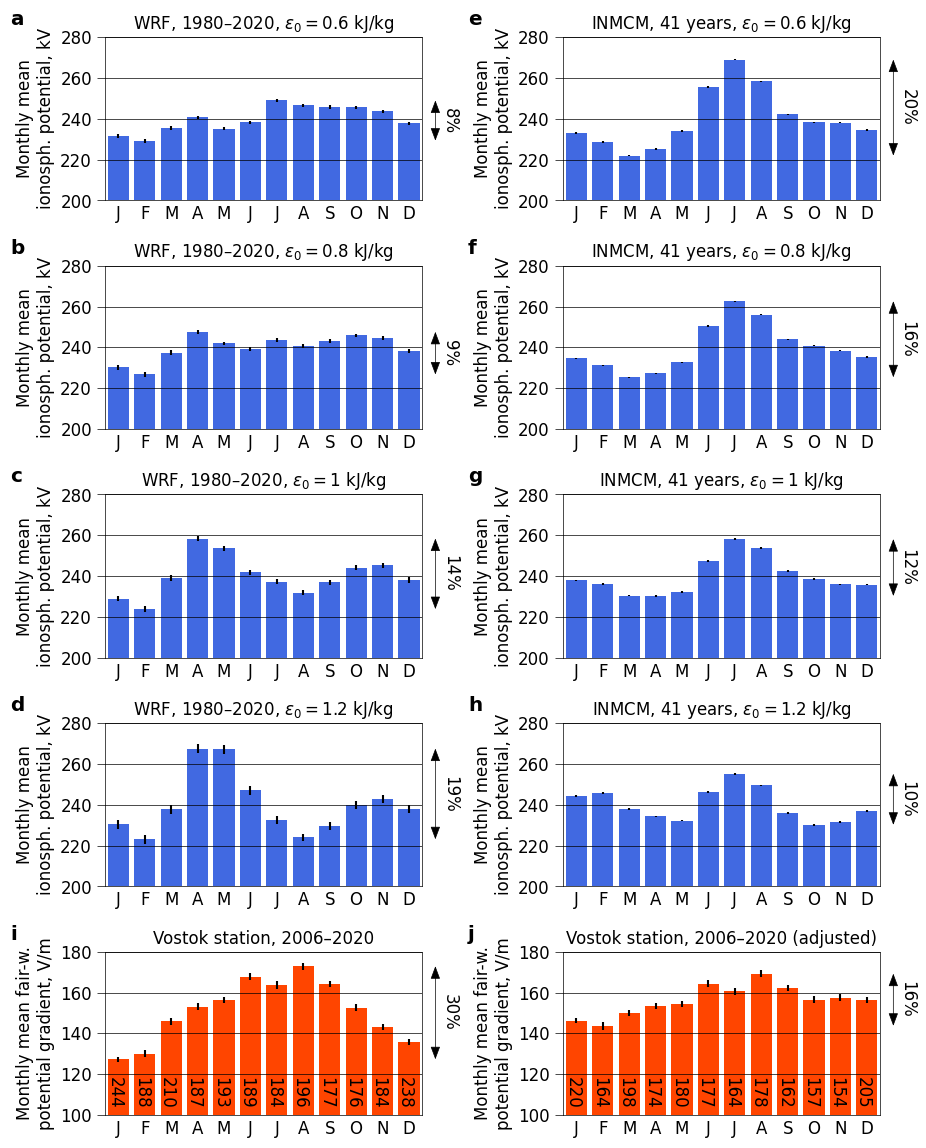

In [9]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(10)]
for n in range(10):
    ax[n] = fig.add_subplot(5, 4, (2*n + 1, 2*n + 2))

low = [200e3] * 8 + [100] * 2
high = [280e3] * 8 + [180] * 2
step = [20e3] * 8 + [20] * 2
coeff = [1e3] * 8 + [1] * 2
caption = ["WRF, 1980–2020, $\\varepsilon_0 = 0.6$ kJ/kg",
           "INMCM, 41 years, $\\varepsilon_0 = 0.6$ kJ/kg",
           "WRF, 1980–2020, $\\varepsilon_0 = 0.8$ kJ/kg",
           "INMCM, 41 years, $\\varepsilon_0 = 0.8$ kJ/kg",
           "WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 41 years, $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 1980–2020, $\\varepsilon_0 = 1.2$ kJ/kg",
           "INMCM, 41 years, $\\varepsilon_0 = 1.2$ kJ/kg",
           "Vostok station, 2006–2020",
           "Vostok station, 2006–2020 (adjusted)"]

col = ["royalblue"] * 8 + ["orangered"] * 2

for n in range(10):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    if n < 8:
        ax[n].set_ylabel("Monthly mean\nionosph. potential, kV",
                         fontsize="large")
    else:
        ax[n].set_ylabel("Monthly mean fair-w.\npotential gradient, V/m",
                         fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.average(data[n], weights=data_counter[n])
    draw_arrows(ax=ax[n],
                miny=np.min(data[n]),
                maxy=np.max(data[n]),
                arrow_pos=12,
                text_pos=12.2,
                ampl=ampl)

fig.align_ylabels([ax[2*i] for i in range(5)])
fig.align_ylabels([ax[2*i+1] for i in range(5)])

for n in range(10):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(8):
    ax[n].text(-0.3, 1.05, chr(ord("a") + 4 * (n % 2) + n // 2),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

for n in range(8, 10):
    ax[n].text(-0.3, 1.05, chr(ord("a") + n),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.4, wspace=1.6)

for n in range(8, 10):
    for m in range(12):
        ax[n].annotate(f"{data_counter[n, m]}",
                       xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                       rotation=270, ha="center", va="bottom",
                       fontsize="large", color="0.")

fig.savefig("figures/ip_pg_total.eps", bbox_inches="tight")

### Figure 2.1
Diurnal variation of the IP and Vostok PG

In [10]:
vostok_diurnal = np.load(
    "./data/Vostok/vostok_diurnal_2006_2020.npy"
)
vostok_diurnal_adjusted = np.load(
    "./data/Vostok/vostok_diurnal_2006_2020_adjusted.npy"
)

In [11]:
wrf_diurnal = {
    cape_thres: wrf_hourly_total_ip[cape_thres].mean(axis=0) / 240e3
    for cape_thres in [600, 800, 1000, 1200]
}
inm_diurnal = {
    cape_thres: inm_hourly_total_ip[cape_thres].mean(axis=0) / 240e3
    for cape_thres in [600, 800, 1000, 1200]
}
vostok_diurnal /= vostok_diurnal.mean()
vostok_diurnal_adjusted /= vostok_diurnal_adjusted.mean()

In [12]:
# making cycles
vostok_diurnal = [
    (vostok_diurnal[0] + vostok_diurnal[-1]) / 2,
    *vostok_diurnal,
    (vostok_diurnal[0] + vostok_diurnal[-1]) / 2]
vostok_diurnal_adjusted = [
    (vostok_diurnal_adjusted[0] + vostok_diurnal_adjusted[-1]) / 2,
    *vostok_diurnal_adjusted,
    (vostok_diurnal_adjusted[0] + vostok_diurnal_adjusted[-1]) / 2]
for cape_thres in [600, 800, 1000, 1200]:
    wrf_diurnal[cape_thres] = [
        *wrf_diurnal[cape_thres],
        wrf_diurnal[cape_thres][0]
    ]
    inm_diurnal[cape_thres] = [
        *inm_diurnal[cape_thres],
        inm_diurnal[cape_thres][0]
    ]

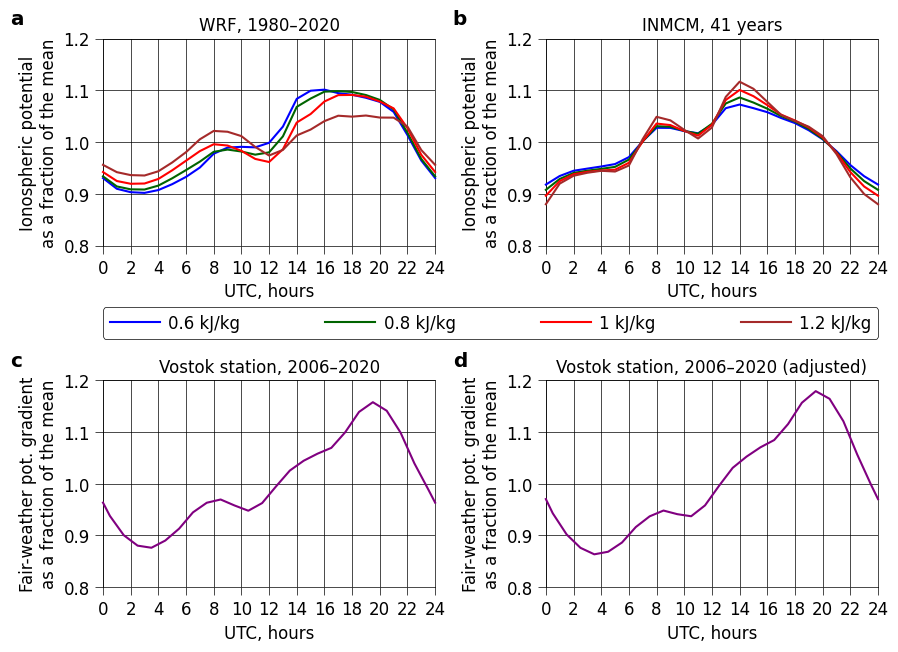

In [13]:
fig = plt.figure(figsize=(10, 16), constrained_layout=False)
ax = [None for _ in range(4)]

for n in range(4):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [0.8] * 4
high = [1.2] * 4
step = [0.1] * 4
coeff = [1] * 4

caption = ["WRF, 1980–2020",
           "INMCM, 41 years",
           "Vostok station, 2006–2020",
           "Vostok station, 2006–2020 (adjusted)"]

for n in range(4):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5)
    ax[n].grid(color="0.", linewidth=0.5)

    ax[n].set_xlim((0, 24))
    ax[n].set_xticks(np.arange(0, 25, 2))
    ax[n].set_xticklabels(np.arange(0, 25, 2), fontsize="large")
    ax[n].set_xlabel("UTC, hours", fontsize="large")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels([f"{x:.1f}" for x in
                           np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]],
                          fontsize="large")
    if n > 1:
        ax[n].set_ylabel("Fair-weather pot. gradient\n"
                         "as a fraction of the mean",
                     fontsize="large")
    else:
        ax[n].set_ylabel("Ionospheric potential\nas a fraction of the mean",
                         fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

fig.align_ylabels([ax[0], ax[2]])
fig.align_ylabels([ax[1], ax[3]])

for cape_thres, col, lab in zip(
    [600, 800, 1000, 1200],
    ["blue", "darkgreen", "red", "brown"],
    ["0.6 kJ/kg", "0.8 kJ/kg", "1 kJ/kg", "1.2 kJ/kg"]
):
    ax[0].plot(np.arange(0, 25),
               wrf_diurnal[cape_thres],
               linewidth=1.5, color=col, clip_on=False,
               zorder=4, label=lab)
    ax[1].plot(np.arange(0, 25),
               inm_diurnal[cape_thres],
               linewidth=1.5, color=col, clip_on=False,
               zorder=4, label=lab)

ax[2].plot(np.append(np.insert(np.arange(0.5, 24, 1), 0, 0), 24),
           vostok_diurnal,
           linewidth=1.5, color="purple", clip_on=False,
           zorder=4)
ax[3].plot(np.append(np.insert(np.arange(0.5, 24, 1), 0, 0), 24),
           vostok_diurnal_adjusted,
           linewidth=1.5, color="purple", clip_on=False,
           zorder=4)

for n in range(4):
    ax[n].text(-0.28, 1.05, chr(ord("a") + n), fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.65, wspace=1.)

leg_width_rel = (ax[1].get_position().x1 - ax[0].get_position().x0) \
    / (ax[0].get_position().x1 - ax[0].get_position().x0)

leg = ax[0].legend(bbox_to_anchor=(0., -0.45, leg_width_rel, 1./6), ncols=4,
                   loc="lower center", borderaxespad=0.,
                   mode="expand", fontsize="large",
                   framealpha=1, edgecolor="0.",
                   handlelength=3., handletextpad=0.5)
leg.get_frame().set_linewidth(0.5)

fig.savefig("figures/ip_pg_diurnal.eps", bbox_inches="tight")

### Figures 2.S2 and 2.S3
Seasonal variation of the IP and Vostok PG for smaller time periods

In [14]:
# calculating seasonal variation parameters for different ranges of years
# 8 sets for different subplots, each set contains 12 monthly values

# monthly mean values of the IP or PG
data = np.zeros((8, 12))

# monthly counts of days
data_counter = np.zeros((8, 12), dtype=int)

# monthly mean values of the IP or PG square
data_sqr = np.zeros((8, 12))

# to construct this figure, we divide the datasets into equal ranges of years
# the dictionary keys below denote the subplot number in the figure
wrf_ranges = {
    0: range(1981, 1990 + 1),
    2: range(1991, 2000 + 1),
    4: range(2001, 2010 + 1),
    6: range(2011, 2020 + 1)
}

inm_ranges = {
    1: range(1, 11),
    3: range(11, 21),
    5: range(21, 31),
    7: range(31, 41)
}

for m in range(12):
    for ax_idx in range(8):
        if ax_idx in wrf_ranges.keys():

            # selecting the days belonging to the specific month
            wrf_inds = [i for i, date in enumerate(wrf_dt_indices)
                        if date.month == m + 1
                        and date.year in wrf_ranges[ax_idx]
                       ]

            # selecting IP values for CAPE = 1000 J/kg and selected month
            ip = wrf_hourly_total_ip[1000][wrf_inds]

            # calculating seasonal variation parameters
            data[ax_idx, m] = ip.mean()
            data_counter[ax_idx, m] = len(ip)
            data_sqr[ax_idx, m] = np.sum(ip.mean(axis=-1) ** 2) / len(ip)

        else:

            # selecting the days belonging to the specific month
            inmcm_inds = [i for i, date in enumerate(inm_dt_indices) 
                          if date.month == m + 1
                          and i//365 in inm_ranges[ax_idx]
                         ]

            # selecting IP values for CAPE = 1000 J/kg and selected month
            ip  = inm_hourly_total_ip[1000][inmcm_inds]

            # calculating seasonal variation parameters
            data[ax_idx, m] = ip.mean()
            data_counter[ax_idx, m] = len(ip)
            data_sqr[ax_idx, m] = np.sum(ip.mean(axis=-1) ** 2) / len(ip)

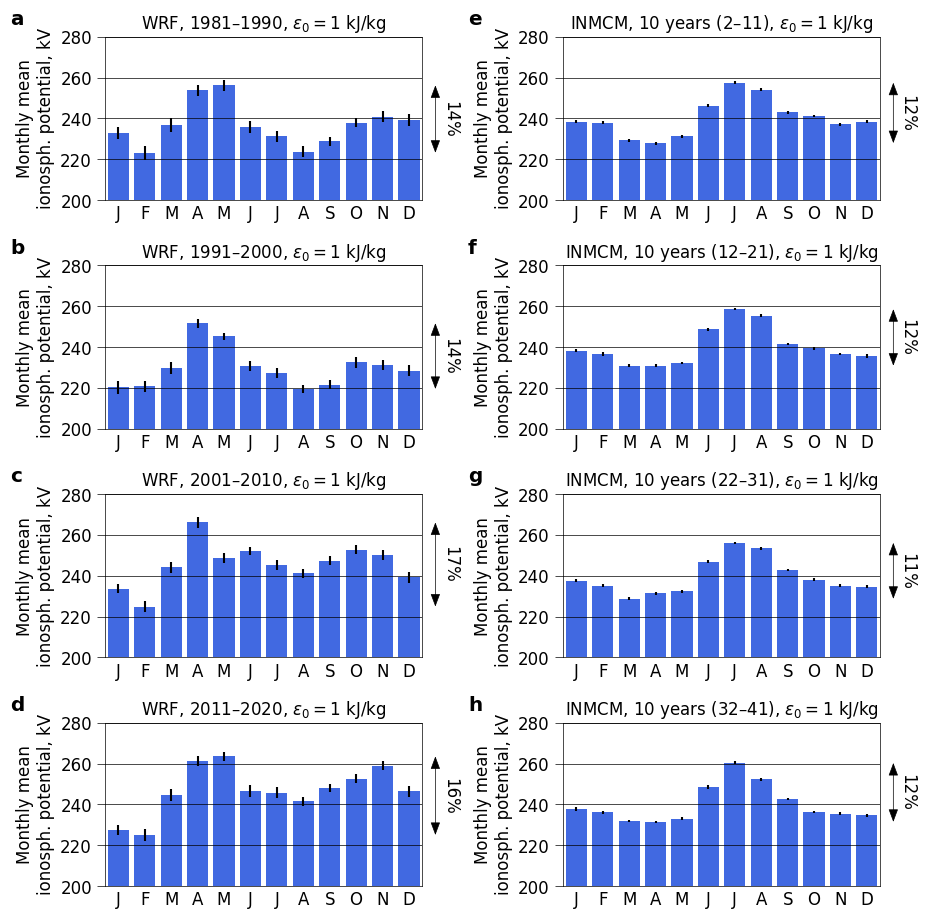

In [15]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(8)]

for n in range(8):
    ax[n] = fig.add_subplot(5, 4, (2*n + 1, 2*n + 2))

low = [200e3] * 8
high = [280e3] * 8
step = [20e3] * 8
coeff = [1e3] * 8

caption = ["WRF, 1981–1990, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 10 years (2–11), $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 1991–2000, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 10 years (12–21), $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 2001–2010, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 10 years (22–31), $\\varepsilon_0 = 1$ kJ/kg",
           "WRF, 2011–2020, $\\varepsilon_0 = 1$ kJ/kg",
           "INMCM, 10 years (32–41), $\\varepsilon_0 = 1$ kJ/kg"]

col = ["royalblue"] * 8

for n in range(8):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    ax[n].set_ylabel("Monthly mean\nionosph. potential, kV",
                     fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.average(data[n], weights=data_counter[n])
    draw_arrows(ax=ax[n],
                miny=np.min(data[n]),
                maxy=np.max(data[n]),
                arrow_pos=12,
                text_pos=12.2,
                ampl=ampl)

fig.align_ylabels([ax[0], ax[2], ax[4], ax[6]])
fig.align_ylabels([ax[1], ax[3], ax[5], ax[7]])

for n in range(8):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(8):
    ax[n].text(-0.3, 1.05,  chr(ord("a") + 4 * (n % 2) + n // 2),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.4, wspace=1.6)

fig.savefig("figures/ip_partial.eps", bbox_inches="tight")

In [16]:
# calculating seasonal variation parameters for different ranges of years
# 4 sets for different subplots, each set contains 12 monthly values

# monthly mean values of the PG
data = np.zeros((4, 12))

# monthly counts of days
data_counter = np.zeros((4, 12), dtype=int)

# monthly mean values of the PG square
data_sqr = np.zeros((4, 12))

# the four sets are loaded from the processed PG data
# from the Vostok station generated in script #2
# the data are loaded as dictionaries with the keys `mean`, `counter`, `sqr`
# index 0: 2006–2020, index 1: 2006–2012, index 2: 2013–2020
vostok_results = np.load(
    "./data/Vostok/vostok_2006_2020_results.npz"
)
vostok_results_adjusted = np.load(
    "./data/Vostok/vostok_2006_2020_results_adjusted.npz"
)

# 2006–2012
data[0] = vostok_results["mean"][1]
data_counter[0] = vostok_results["counter"][1]
data_sqr[0] = vostok_results["sqr"][1]
data[1] = vostok_results_adjusted["mean"][1]
data_counter[1] = vostok_results_adjusted["counter"][1]
data_sqr[1] = vostok_results_adjusted["sqr"][1]

# 2013–2020
data[2] = vostok_results["mean"][2]
data_counter[2] = vostok_results["counter"][2]
data_sqr[2] = vostok_results["sqr"][2]
data[3] = vostok_results_adjusted["mean"][2]
data_counter[3] = vostok_results_adjusted["counter"][2]
data_sqr[3] = vostok_results_adjusted["sqr"][2]

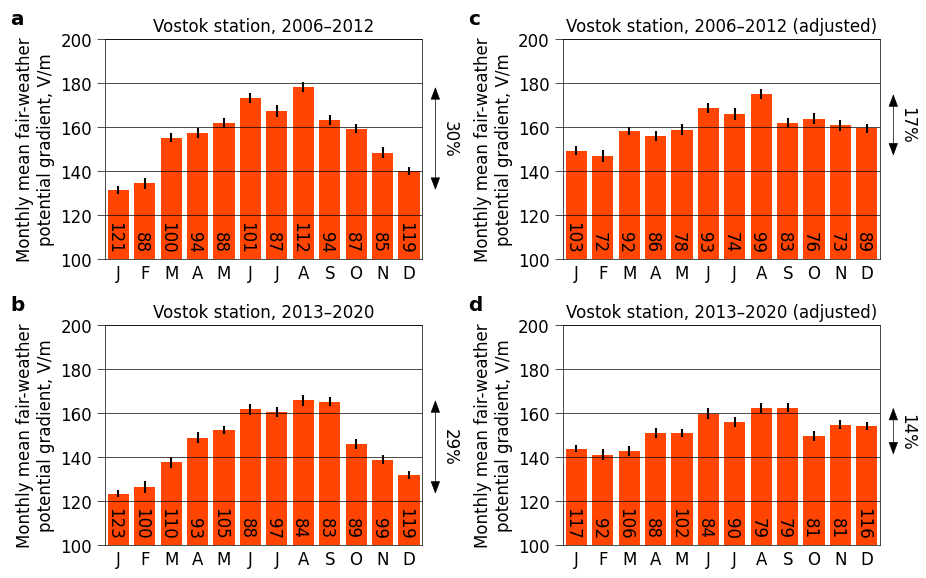

In [17]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(4)]

for n in range(4):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [100] * 4
high = [200] * 4
step = [20] * 4
coeff = [1] * 4

caption = ["Vostok station, 2006–2012",
           "Vostok station, 2006–2012 (adjusted)",
           "Vostok station, 2013–2020",
           "Vostok station, 2013–2020 (adjusted)"]

col = ["orangered"] * 4

for n in range(4):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    ax[n].set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
                     fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.average(data[n], weights=data_counter[n])
    draw_arrows(ax=ax[n],
                miny=np.min(data[n]),
                maxy=np.max(data[n]),
                arrow_pos=12,
                text_pos=12.2,
                ampl=ampl)

fig.align_ylabels([ax[0], ax[2]])
fig.align_ylabels([ax[1], ax[3]])

for n in range(4):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(4):
    ax[n].text(-0.3, 1.05, chr(ord("a") + 2 * (n % 2) + n // 2),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for n in range(4):
    for m in range(12):
        ax[n].annotate(f"{data_counter[n, m]}",
                       xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                       rotation=270, ha="center", va="bottom",
                       fontsize="large", color="0.")

fig.savefig("figures/pg_partial_corrected.eps", bbox_inches="tight")